<center><h1>Biblical Hebrew Time Adverbials and their Semantic Heads</h1></center>
<center><h2 style="font-weight:normal">Cody Kingham</h2></center>
<center><h2><a href="../../docs/sponsors.md"><img height=10% width=10% src="../../docs/images/CambridgeU_BW.png"></a></h2></center>

In [1]:
! echo "last updated:"; date

last updated:
Mon 30 Dec 2019 15:54:33 GMT


## Introduction

Time adverbials are phrases which modify event time in a clause. These phrases typically contain a word that lexicalizes a time referent or quality. In traditional syntactic analysis, phrases are built up from their heads. Newer approaches like Construction Grammar (adopted herein) likewise use the notion of a "central idea" or "primary information bearing unit" (Croft 2001, 258–9). For the purpose of this study, we will refer to these units as "semantic heads." My [earlier analyses](../../archive/2019-10-31/analysis/exploratory/construction_distribution.ipynb) demonstrated that time adverbials contain heads that are statistically associated with the time function. Or, in other words, time adverbial head words are often specialized for the task of conveying time. This observation suggests that time adverbial heads are a good starting point for analyzing their semantics. They are the most specialized and specific semantic unit in the time adverbial.

The goals of this notebook is to:
* examine the distribution of time adverbials throughout the corpus
* identify and quantify the primary surface forms found amongst time adverbials as tagged in the project dataset (BHSA + modifications)
* identify and quantify the semantic head lexemes found on time adverbials in the dataset
* identify collocational tendencies of semantic head lexemes with other constructions

<hr>

<center><h2>Python</h2></center>

## Import Modules and Data

In [2]:
# standard packages
from pathlib import Path
import collections
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# custom package in /tools
from paths import figs
from helpers import Figures, convert2pandas
from tf_tools.load import load_tf
from tf_tools.tokenizers import tokenize_surface
from cx_analysis.load import cxs
from cx_analysis.search import SearchCX
from stats.significance import contingency_table, apply_fishers

TF, API, A = load_tf(silent='deep')
A.displaySetup(condenseType='phrase')
F, E, T, L = A.api.F, A.api.E, A.api.T, A.api.L
se = SearchCX(A)
phrase2cxs = cxs['phrase2cxs']
class2cx = cxs['class2cx']
time_cxs = list(phrase2cxs.values())

## Data Output

In [36]:
fg = Figures()

In [37]:
chapter = 'times_and_heads'
figures = figs.joinpath(chapter)
if not figures.exists():
    figures.mkdir(parents=True)
    
def fg_path(fg_name):
    return figures.joinpath(fg.title(fg_name))

## Dataset

The core data is from the ETCBC's BHSA syntactic corpus. This data has been further corrected and refined in the [bhsa](../../data/bhsa) and [cxs](../../data/cxs) directories of this project. BHSA provides the phrases themselves, which are in some cases corrected or modified. The syntactic structure of a phrase is subsequently analyzed using a series of constructional patterns (also in [cxs](../../data/cxs)). The structure is stored as a directed graph, and can be accessed using NetworkX methods. The data in the `cxs` import above is a Python dictionary which contains custom classes built for this project, the `Construction` object. Each object represents a phrase in the corpus, and contains the syntactic graphs. 

In [27]:
cxs.keys()

dict_keys(['wordcxs', 'phrase2cxs', 'class2cx'])

NB: Some Python-ese follows. `wordcxs` is a set of `Construction` objects that describe certain word instances in the Hebrew Bible. `phrase2cxs` is a dictionary containing mappings from a custom BHSA node number (integer), the `timephrase`, to its `Construction` object. `class2cx` is also a dictionary that maps certain pre-processed class tags to their respective constructions. For example, a tag "prep" contains all time phrases that begin with a preposition.

To illustrate, let's start with the custom BHSA node-type, the `timephrase`. This node is built from BHSA `phrase` nodes with a `function` value of `Time`. In some cases, BHSA separates these time phrases into seperate units. This separation is undesirable for the purposes of our analysis. The `timephrase` solves this problem by merging all adjacent phrases with a function of `Time`.

The numerical difference between `phrase` and `timephrase` is show below.

In [52]:
phrases = A.search('phrase function=Time')

  0.26s 4677 results


In [53]:
timephrases = A.search('timephrase')

  0.01s 4455 results


In [54]:
print(f'difference of {len(phrases) - len(timephrases)}')

difference of 222


The `timephrase` nodes have been wrapped into `Construction` objects and are stored under `time_cxs`. Let's have a look.

In [28]:
time_cxs[:5]

[[CX prep_ph (1, 2)],
 [CX prep_ph (687, 688, 689, 690, 691)],
 [CX prep_ph (697, 698, 699, 700, 701)],
 [CX prep (750,)],
 [CX prep (760,)]]

Each time construction contains a list of subphrases, which together function as a single time adverbial. Let's visualize the first one.

In [29]:
se.showcx(time_cxs[0][0])

{   '__cx__': 'prep_ph',
    'head': {'__cx__': 'cont', 'head': 2},
    'prep': {'__cx__': 'prep', 'head': 1}}



## Distribution

In [39]:
strip_data = []
covered_chapters = set()
bookboundaries = {}

twelve = ('Hosea', 'Joel', 'Amos', 'Obadiah',
          'Jonah', 'Micah', 'Nahum', 'Habakkuk',
          'Zephaniah', 'Haggai', 'Zechariah',
          'Malachi')

# map grouped book names
megilloth = ('Ruth', 'Lamentations', 'Ecclesiastes', 'Esther', 'Song_of_songs')
book_map = {'1_Kings': 'Kings', '2_Kings':'Kings', '1_Samuel':'Samuel',
            '2_Samuel':'Samuel', '1_Chronicles':'Chronicles', '2_Chronicles':'Chronicles',}
for book in twelve: book_map[book] = 'Twelve'
for book in megilloth: book_map[book] = 'Megilloth'
for book in ('Ezra', 'Nehemiah', 'Daniel'): book_map[book] = 'Daniel-Neh'

    
# iterate through constructions and gather book data
this_book = None

for subphrases in time_cxs:
    ref_node = int(subphrases[0])
    chapter_node = L.u(ref_node, 'chapter')[0]
    book, chapter, verse = T.sectionFromNode(ref_node)
    this_book = book_map.get(book, book)
    covered_chapters.add(chapter_node)
    chapter_label = len(covered_chapters)
    
    if this_book not in bookboundaries: # add first chapter to boundaries for plotting
        bookboundaries[this_book] = chapter_label
    
    strip_data.append(chapter_label)

Distribution of Time Function Constructions by Chapter (smaller books are grouped together)


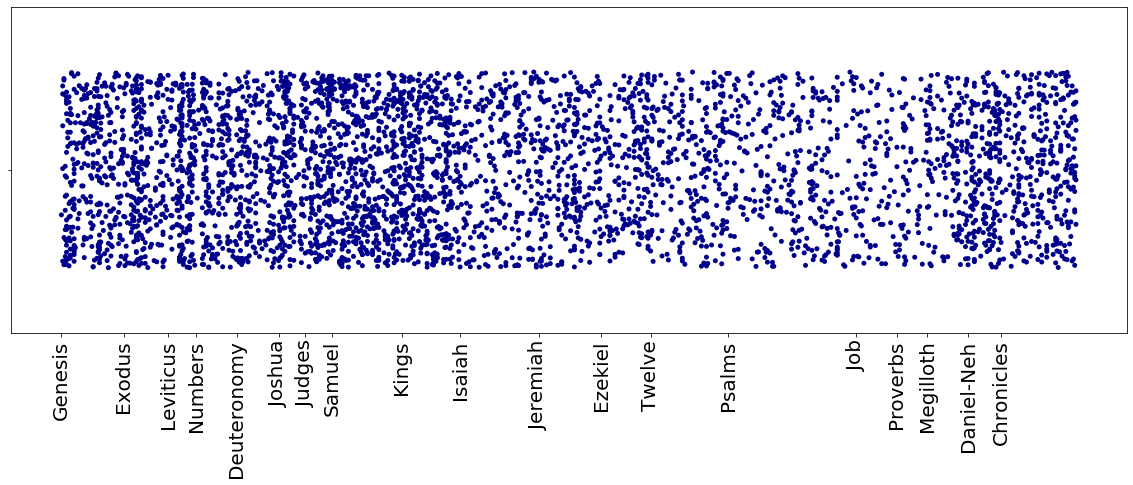

In [40]:
strip_title = 'Distribution of Time Function Constructions by Chapter (smaller books are grouped together)'
plt.figure(figsize=(20, 6))
sns.stripplot(x=strip_data, jitter=0.3, color='darkblue')
plt.xticks(ticks=list(bookboundaries.values()), labels=list(bookboundaries.keys()), rotation='vertical', size=20)
plt.savefig(fg_path('chapter_distribution.png'), dpi=300, bbox_inches='tight')
print(strip_title) # keep title out of savefig
plt.show()